<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/CNN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install braindecode

In [ ]:
import numpy as np
import pandas as pd


from braindecode.datasets import BaseConcatDataset, BaseDataset
from braindecode.util import create_mne_dummy_raw

In [ ]:
def fake_regression_dataset(n_fake_recs, n_fake_chs, fake_sfreq,
                            fake_duration, n_fake_targets,
                            fake_data_split = [0.6, 0.2, 0.2]):
  datasets = []
  for i in range(n_fake_recs):
    if i < int(fake_data_split[0] * n_fake_recs):
      target_subset = "train"
    elif i < int(1 - fake_data_split[2] * n_fake_recs):
      target_subset = "valid"
    else:
      target_subset = "test"

    raw, _ = create_mne_dummy_raw(n_channels = n_fake_chs,
                                  n_times = fake_duration * fake_sfreq,
                                  sfreq = fake_sfreq)


    target = np.random.randint(0, 10, n_fake_targets)
    for j in range(n_fake_targets):
      x = np.sin(2* np.pi * target[j] * raw.times)
      raw._data += np.expand_dims(x, axis = 0)

    if n_fake_targets ==  1:
        target = target[0]
    fake_description = pd.Series(data = [target, target_subset],
                                 index = ["target", "session"])

    datasets.append(
        BaseDataset(raw, fake_description,target_name = "target"))


  return BaseConcatDataset(datasets)

In [ ]:
n_fake_rec = 20
n_fake_chans = 21
fake_sfreq = 100
fake_duration = 30
n_fake_targets = 1
dataset = fake_regression_dataset(n_fake_recs = n_fake_rec,
                                  n_fake_chs = n_fake_chans,
                                  fake_sfreq = fake_sfreq,
                                  fake_duration = fake_duration,
                                  n_fake_targets = n_fake_targets)

Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.990 secs
Ready.
Creating RawArray with float64 data, n_channels=21, n_times=3000
    Range : 0 ... 2999 =      0.000 ...    29.

In [ ]:
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet
import torch

model_name = "shallow"


if model_name in ["shallow", "Shallow", "ShallowConvNet"]:
  model = ShallowFBCSPNet(in_chans = n_fake_chans,
                          n_classes = n_fake_targets,
                          input_window_samples = fake_sfreq * fake_duration,
                          n_filters_time = 40, n_filters_spat = 40,
                          final_conv_length=35,
                          add_log_softmax = False)

elif model_name in ["deep", "Deep", "DeepConvNet"]:
  model = Deep4Net(in_chans = n_fake_chans, n_classes = n_fake_targets,
                     input_window_samples = fake_sfreq * fake_duration,
                     n_filters_time = 25, n_filtersspat = 25,
                     stride_before_pool = True,
                     n_filters_2 = n_fake_chans * 2,
                     n_filters_3 = n_fake_chans * 4,
                     n_filters_4 = n_fake_chans * 8,
                     final_conv_length = 1,
                     add_log_softmax = False)
else:
  raise ValueError(f'{model_name} unknown')



/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'in_chans' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


In [ ]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
  torch.backends.cudnn.benchmark = True


seed = 20200220
set_random_seeds(seed = seed, cuda = cuda)
if cuda:
  model.cuda()

In [ ]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.preprocessing import create_fixed_length_windows

window_size_samples = fake_sfreq * fake_duration
# to_dense_prediction_model(model)
n_preds_per_input = get_output_shape(model, n_fake_chans, window_size_samples)[2]


windows_dataset = create_fixed_length_windows(
    dataset,
    start_offset_samples = 0,
    stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window = False,
    preload = True
)

splits = windows_dataset.split("session")
train_set = splits["train"]
# valid_set = splits["valid"]
test_set = splits["test"]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function get_output_shape is deprecated; will be removed in version 1.0. Use EEGModuleMixin.get_output_shape method directly on the model object.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/windowers.py:610: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


In [ ]:
splits["test"]

In [ ]:
from braindecode import EEGRegressor
from braindecode.training.losses import CroppedLoss
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from skorch.dataset import ValidSplit
batch_size = 4
n_epochs = 3
optimizer_lr = 0.001
optimizer_weight_decay = 0.0
regressor =EEGRegressor(model, cropped = True,
                        criterion = CroppedLoss,
                        criterion__loss_function = torch.nn.functional.mse_loss,
                        optimizer = torch.optim.AdamW,
                        optimizer__lr = optimizer_lr,
                        optimizer__weight_decay = optimizer_weight_decay,
                        train_split = ValidSplit(0.2, random_state = seed),
                        iterator_train__shuffle = True,
                        batch_size = batch_size,
                        callbacks = ["neg_root_mean_squared_error",
                                     ("lr_scheduler",
                                      LRScheduler('CosineAnnealingLR',
                                                  T_max = n_epochs - 1))],
                        device = device)
regressor.fit(train_set, y = None, epochs = n_epochs)

  epoch    train_loss    train_neg_root_mean_squared_error    valid_loss    valid_neg_root_mean_squared_error      lr     dur
-------  ------------  -----------------------------------  ------------  -----------------------------------  ------  ------
      1       27.2720                              -6.0068       33.5114                              -5.7889  0.0010  0.3977
      2       12.7621                              -5.3862       22.4160                              -4.7346  0.0005  0.5442
      3        8.9105                              -4.9875       19.6837                              -4.4366  0.0000  0.5602


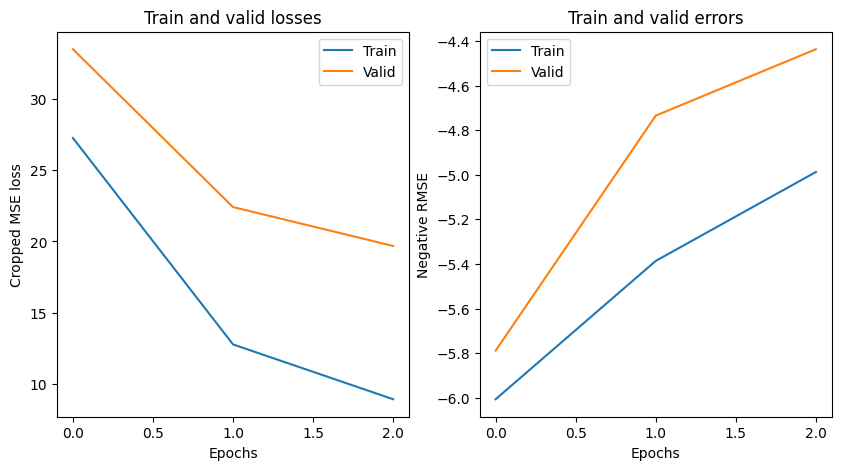

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].set_title("Train and valid losses")
axes[0].plot(regressor.history[:, "train_loss"])
axes[0].plot(regressor.history[:, "valid_loss"])
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cropped MSE loss")
axes[0].legend(["Train", "Valid"])


axes[1].set_title("Train and valid errors")
axes[1].plot(regressor.history[:, "train_neg_root_mean_squared_error"])
axes[1].plot(regressor.history[:, "valid_neg_root_mean_squared_error"])
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Negative RMSE")
axes[1].legend(["Train", "Valid"])



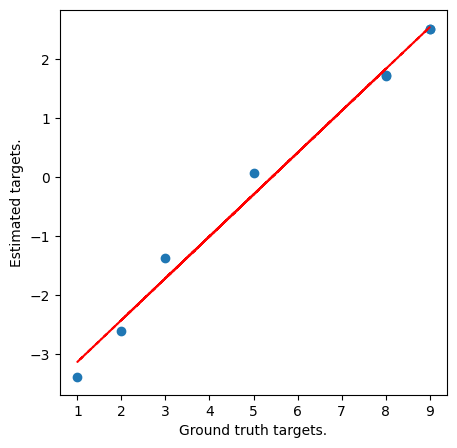

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (5, 5))
y_estim = np.ravel(regressor.predict(test_set))
y_gt = test_set.get_metadata()["target"].to_numpy()

_ = axes.scatter(y_gt, y_estim)
_ = axes.set_ylabel("Estimated targets.")
_ = axes.set_xlabel("Ground truth targets.")


z = np.polyfit(y_gt, y_estim, 1)
p = np.poly1d(z)
plt.plot(y_gt, p(y_gt), "r--")
plt.show()